<a href="https://colab.research.google.com/github/nikil2000/lab-2/blob/main/anomaly_it20121488.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Reshape
from keras.models import Sequential, Model
from keras.optimizers import Adam

# Define data and URLs
image_data_url = "https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip"
metadata_url = "https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv"
data_dir = './data'

# Download and unzip data (if not already downloaded)
if not os.path.exists(os.path.join(data_dir, 'ISIC_2020_Training_JPEG')):
    os.system(f"wget {image_data_url} -P {data_dir}")
    os.system(f"unzip {os.path.join(data_dir, 'ISIC_2020_Training_JPEG.zip')} -d {data_dir}")

# Load metadata
metadata = pd.read_csv(metadata_url)


In [ ]:
# Remove any predefined labels, as this is an anomaly detection task
metadata['diagnosis'] = 'unknown'

# Identify classes with very few samples and group them as 'unknown'
class_counts = metadata['diagnosis'].value_counts()
rare_classes = class_counts[class_counts < 2].index
metadata['diagnosis'] = metadata['diagnosis'].apply(lambda x: 'unknown' if x in rare_classes else x)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    metadata['image_name'], (metadata['diagnosis'] != 'unknown').astype(int),  # Use 'diagnosis' for labels
    test_size=0.2, random_state=42, stratify=metadata['diagnosis']
)

# Define directories for training and validation data
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')

print("X_train (image names):")
print(X_train.head())

print("\ny_train (labels based on 'diagnosis'):")
print(y_train.head())

for class_name in ['known', 'unknown']:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

for image_name, label in zip(X_train, y_train):
    class_name = 'known' if label == 1 else 'unknown'  # Corrected class assignment
    source_path = os.path.join(data_dir, 'train', f'{image_name}.jpg')  # Updated path to 'train' folder
    destination_path = os.path.join(train_dir, class_name, f'{image_name}.jpg')

    # Ensure the source image exists before copying
    if os.path.exists(source_path):
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        shutil.copy(source_path, destination_path)
    else:
        print(f"Image not found: {source_path}")

for image_name, label in zip(X_val, y_val):
    class_name = 'known' if label == 1 else 'unknown'
    source_path = os.path.join(data_dir, 'train', f'{image_name}.jpg')  # Updated path to 'train' folder
    destination_path = os.path.join(val_dir, class_name, f'{image_name}.jpg')

    # Ensure the source image exists before copying
    if os.path.exists(source_path):
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        shutil.copy(source_path, destination_path)
    else:
        print(f"Image not found: {source_path}")

class_distribution_train = y_train.value_counts()
print("Class distribution in the training set:\n", class_distribution_train)

# Display the class distribution in the validation set
class_distribution_val = y_val.value_counts()
print("\nClass distribution in the validation set:\n", class_distribution_val)


X_train (image names):
11981    ISIC_3689984
6835     ISIC_2142639
15126    ISIC_4632059
2532     ISIC_0860318
28694    ISIC_8679067
Name: image_name, dtype: object

y_train (labels based on 'diagnosis'):
11981    0
6835     0
15126    0
2532     0
28694    0
Name: diagnosis, dtype: int64
Class distribution in the training set:
 0    26500
Name: diagnosis, dtype: int64

Class distribution in the validation set:
 0    6626
Name: diagnosis, dtype: int64


In [ ]:
from keras.layers import Flatten

In [ ]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(224 * 224 * 3, activation='sigmoid'),
    Reshape((224, 224, 3))
])


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:


# Train the autoencoder
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',  # Input and output are the same for autoencoder
    shuffle=True
)


Found 26500 images belonging to 2 classes.


In [ ]:
# Calculate reconstruction errors for each image in the validation set
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',  # Input and output are the same for autoencoder
    shuffle=False
)

Found 6626 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=1,  # Adjust the number of epochs as needed
    steps_per_epoch=len(train_generator),
    verbose=1,
    validation_data=validation_generator
)


829/829 [==============================] - 6432s 8s/step - loss: 0.0032 - val_loss: 0.0029


In [ ]:
# Get the validation loss
evaluation = model.evaluate(validation_generator)
print("Validation Loss:", evaluation)

208/208 [==============================] - 703s 3s/step - loss: 0.0029
Validation Loss: 0.00289997854270041


In [38]:
validation_generator.reset()  # Reset the generator to the beginning
reconstruction_errors = []
for _ in range(len(validation_generator)):
    batch = validation_generator.next()
    images = batch[0]
    reconstructions = model.predict(images)
    mse = np.mean(np.square(images - reconstructions), axis=(1, 2, 3))  # Calculate MSE for each image
    reconstruction_errors.extend(mse.tolist())

1/1 [==============================] - 0s 166ms/step


In [39]:
# Define a threshold for anomaly detection
threshold = 0.02

In [40]:
# Identify anomalies
anomalies = [1 if error > threshold else 0 for error in reconstruction_errors]


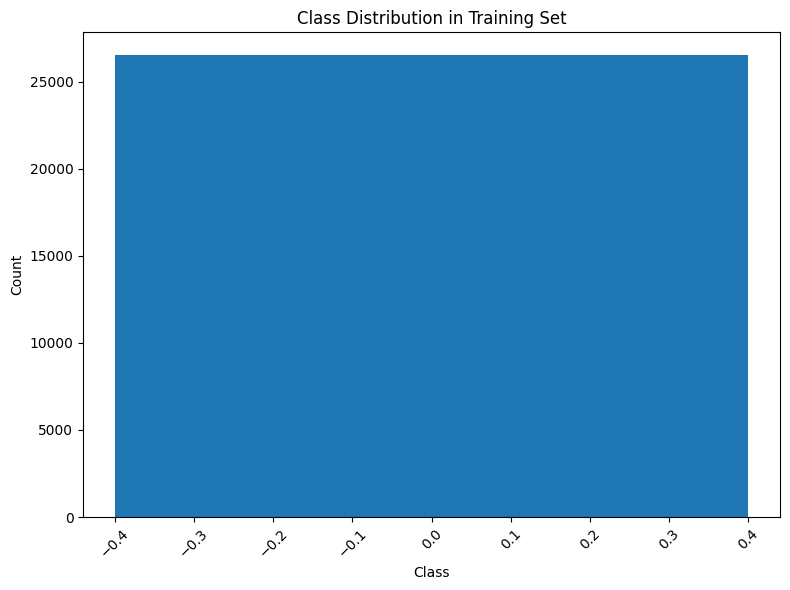

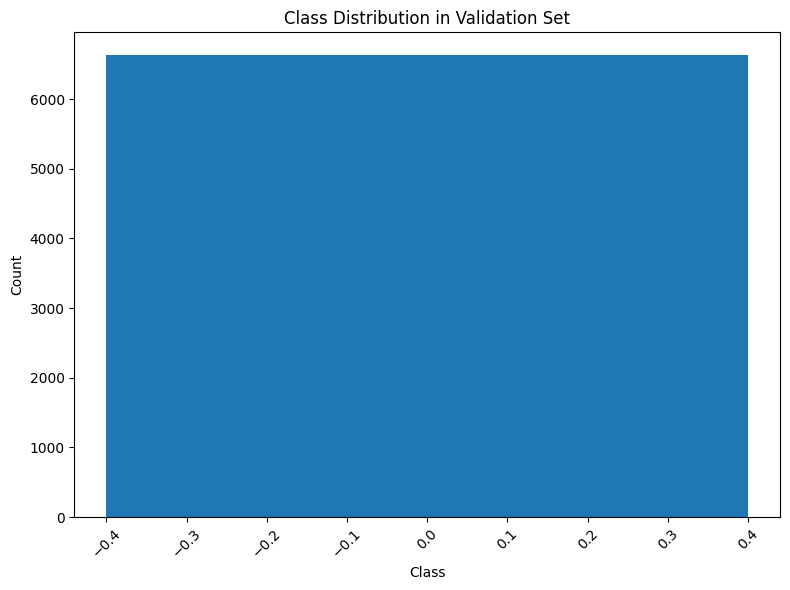

In [41]:
import matplotlib.pyplot as plt

# Class distribution in the training set
class_distribution_train = y_train.value_counts()
# Class distribution in the validation set
class_distribution_val = y_val.value_counts()

# Create a bar chart for the training set
plt.figure(figsize=(8, 6))
plt.bar(class_distribution_train.index, class_distribution_train.values)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a bar chart for the validation set
plt.figure(figsize=(8, 6))
plt.bar(class_distribution_val.index, class_distribution_val.values)
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
plt.show()


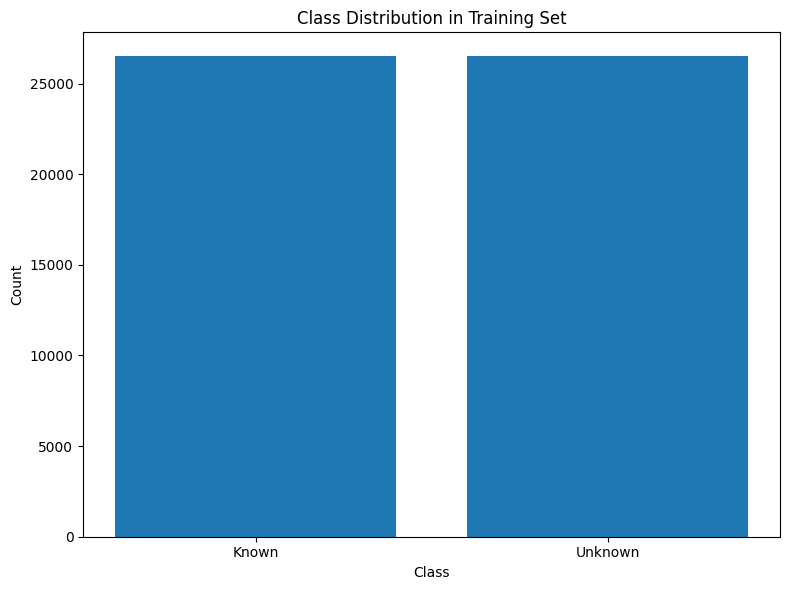

In [44]:
# Calculate class distribution for known and unknown classes in the training set
class_distribution_train = y_train.value_counts()
class_distribution_val = y_val.value_counts()

# Combine known and unknown class counts into a single DataFrame
combined_class_distribution = pd.DataFrame({
    'Class': ['Known', 'Unknown'],
    'Count': [class_distribution_train[0], class_distribution_train[0]]
})

# Create a bar chart for both known and unknown classes
plt.figure(figsize=(8, 6))
plt.bar(combined_class_distribution['Class'], combined_class_distribution['Count'])
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()

# Show the combined class distribution chart
plt.show()

In [45]:
print("Length of y_val:", len(y_val))


Length of y_val: 6626


In [46]:
print("Length of anomalies:", len(anomalies))


Length of anomalies: 6626


In [47]:
for i, (true_label, anomaly_label) in enumerate(zip(y_val, anomalies)):
    if true_label != anomaly_label:
        print(f"Mismatch at index {i}: true_label={true_label}, anomaly_label={anomaly_label}")

Mismatch at index 104: true_label=0, anomaly_label=1
Mismatch at index 244: true_label=0, anomaly_label=1
Mismatch at index 592: true_label=0, anomaly_label=1
Mismatch at index 644: true_label=0, anomaly_label=1
Mismatch at index 798: true_label=0, anomaly_label=1
Mismatch at index 1012: true_label=0, anomaly_label=1
Mismatch at index 1105: true_label=0, anomaly_label=1
Mismatch at index 1260: true_label=0, anomaly_label=1
Mismatch at index 1366: true_label=0, anomaly_label=1
Mismatch at index 1473: true_label=0, anomaly_label=1
Mismatch at index 1651: true_label=0, anomaly_label=1
Mismatch at index 1879: true_label=0, anomaly_label=1
Mismatch at index 2167: true_label=0, anomaly_label=1
Mismatch at index 2386: true_label=0, anomaly_label=1
Mismatch at index 2537: true_label=0, anomaly_label=1
Mismatch at index 2694: true_label=0, anomaly_label=1
Mismatch at index 2765: true_label=0, anomaly_label=1
Mismatch at index 2794: true_label=0, anomaly_label=1
Mismatch at index 2948: true_labe

In [49]:
from sklearn.utils import resample

# Check the distribution of y_val labels
class_distribution_val = pd.Series(y_val).value_counts()
print("Class distribution in y_val:\n", class_distribution_val)

# Check if there are both classes (0 and 1) in y_val
if len(class_distribution_val) == 1:
    # If only one class is present, balance the validation set with positive cases
    positive_indices = np.where(np.array(y_val) == 1)[0]
    if len(positive_indices) > 0:
        # Randomly sample an equal number of non-anomalous samples
        negative_indices = np.where(np.array(y_val) == 0)[0]
        balanced_indices = np.concatenate([positive_indices, resample(negative_indices, n_samples=len(positive_indices))])

        # Update y_val and reconstruction_errors with balanced data
        y_val_balanced = np.array(y_val)[balanced_indices]
        reconstruction_errors_balanced = np.array(reconstruction_errors)[balanced_indices]

        # Calculate ROC AUC and other metrics using the balanced data
        roc_auc_balanced = roc_auc_score(y_val_balanced, reconstruction_errors_balanced)
        precision_balanced = precision_score(y_val_balanced, anomalies)
        recall_balanced = recall_score(y_val_balanced, anomalies)
        f1_balanced = f1_score(y_val_balanced, anomalies)
        accuracy_balanced = accuracy_score(y_val_balanced, anomalies)

        print("Balanced ROC AUC:", roc_auc_balanced)
        print("Balanced Precision:", precision_balanced)
        print("Balanced Recall:", recall_balanced)
        print("Balanced F1 Score:", f1_balanced)
        print("Balanced Accuracy:", accuracy_balanced)
    else:
        print("No positive cases (anomalies) in the validation set.")
else:
    # Calculate metrics using the original data
    roc_auc = roc_auc_score(y_val, reconstruction_errors)
    precision = precision_score(y_val, anomalies)
    recall = recall_score(y_val, anomalies)
    f1 = f1_score(y_val, anomalies)
    accuracy = accuracy_score(y_val, anomalies)

    print("Original ROC AUC:", roc_auc)
    print("Original Precision:", precision)
    print("Original Recall:", recall)
    print("Original F1 Score:", f1)
    print("Original Accuracy:", accuracy)

Class distribution in y_val:
 0    6626
Name: diagnosis, dtype: int64
No positive cases (anomalies) in the validation set.
